In [50]:
from PIL import Image
from pydantic import BaseModel, Field, field_serializer, computed_field, model_serializer
from pathlib import Path
import base64
import rich
import json

from tqdm.auto import tqdm

import instructor

import openai
import anthropic

In [20]:
gpt_client = instructor.from_openai(
    openai.OpenAI(), mode=instructor.Mode.MD_JSON
)
claude_client = instructor.from_anthropic(
    anthropic.Anthropic(), mode=instructor.Mode.ANTHROPIC_JSON
)


In [3]:
class HandwrittenText(BaseModel):
    """Text extracted from a handwritten doctor's note. 
    The document may be a printed form with handwritten information or a page
    of handwritten notes.
    """
    raw_text: str = Field(
        ..., 
        description="The raw text extracted from the handwritten document."
    )
    md_text: str = Field(
        ..., 
        description="""\
            A markdown formatted version of the handwritten text.
            The text is formatted to be suitable for a markdown viewer.
            The text should be organized in a way that is easy to read.
        """
    )



In [21]:
def load_image(path: Path) -> Image.Image:
    return Image.open(path)

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    b64str = base64.b64encode(image_file.read()).decode('utf-8')
    return f"{b64str}"

image_dir = Path(".").resolve().parent / "data/notes"
image_paths = sorted(image_dir.glob("*.jpeg"), key=lambda p: p.stem)
image_paths

[PosixPath('/mnt/arrakis/meddibia/meddibia-demos/data/notes/agbo-esther-1.jpeg'),
 PosixPath('/mnt/arrakis/meddibia/meddibia-demos/data/notes/agbo-esther-2.jpeg'),
 PosixPath('/mnt/arrakis/meddibia/meddibia-demos/data/notes/agbo-esther-3.jpeg'),
 PosixPath('/mnt/arrakis/meddibia/meddibia-demos/data/notes/agbo-esther-4.jpeg'),
 PosixPath('/mnt/arrakis/meddibia/meddibia-demos/data/notes/agbo-esther-5.jpeg'),
 PosixPath('/mnt/arrakis/meddibia/meddibia-demos/data/notes/agbo-esther-6.jpeg'),
 PosixPath('/mnt/arrakis/meddibia/meddibia-demos/data/notes/john-salomi-1.jpeg'),
 PosixPath('/mnt/arrakis/meddibia/meddibia-demos/data/notes/john-salomi-2.jpeg'),
 PosixPath('/mnt/arrakis/meddibia/meddibia-demos/data/notes/john-salomi-3.jpeg'),
 PosixPath('/mnt/arrakis/meddibia/meddibia-demos/data/notes/ugwu-aldine-1.jpeg'),
 PosixPath('/mnt/arrakis/meddibia/meddibia-demos/data/notes/ugwu-aldine-2.jpeg'),
 PosixPath('/mnt/arrakis/meddibia/meddibia-demos/data/notes/ugwu-aldine-3.jpeg'),
 PosixPath('/mnt

In [51]:
GPT = instructor.from_openai(openai.OpenAI(), mode=instructor.Mode.MD_JSON)
CLAUDE = instructor.from_anthropic(
    anthropic.Client(), mode=instructor.Mode.ANTHROPIC_JSON
)

class Note(BaseModel):
    path: Path
    extracted_claude: HandwrittenText | None = None
    extracted_gpt: HandwrittenText | None = None

    @computed_field
    def name(self) -> str:
        return self.path.stem

    @computed_field
    def image(self) -> Image.Image:
        return load_image(self.path)

    @computed_field
    def image_base64(self) -> str:
        return encode_image(self.path)

    @field_serializer("path")
    def path_serializer(path: Path):
        return str(path)
    
    def dict(self):
        return {k: v for k, v in self.model_dump().items() if k not in ["image", "image_base64"]}
    
    class Config:
        arbitrary_types_allowed = True
    


def extract_with_claude(note: Note):
    res = CLAUDE.chat.completions.create(
        model="claude-3-opus-20240229",
        response_model=HandwrittenText,
        temperature=0.0,
        system="""\
            You are an expert handwritten text extractor.
            You are given a handwritten doctor's note and you are asked to extract the text.
            The text should be in markdown format.
        """,
        max_tokens=2048,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/jpeg",
                            "data": note.image_base64,
                        },
                    },
                    {"type": "text", "text": "Extract the text from the image."},
                ],
            }
        ],
    )
    return res


def extract_with_gpt(note: Note):
    res = GPT.chat.completions.create(
        model="gpt-4o",
        response_model=HandwrittenText,
        temperature=0.0,
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Extract the text from the image."},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{note.image_base64}"
                        },
                    },
                ],
            }
        ],
    )
    return res


data = []

with tqdm(image_paths) as pbar:
    for p in pbar:
        note = Note(path=p)
        pbar.set_postfix({"note": note.name})

        pbar.set_description("Extracting with Claude")
        note.extracted_claude = extract_with_claude(note)
        pbar.set_description("Extracting with GPT")
        note.extracted_gpt = extract_with_gpt(note)

        data.append(note)


  0%|          | 0/13 [00:00<?, ?it/s]

In [55]:
with open("/mnt/arrakis/meddibia/meddibia-demos/data/notes/data.json", "w") as f:
    json.dump([d.dict() for d in data], f)



In [24]:
img = load_image(image_paths[0])
img64 = encode_image(image_paths[0])

res = claude_client.chat.completions.create(
    model="claude-3-opus-20240229",
    response_model=HandwrittenText,
    temperature=0.0,
    system="""\
        You are an expert handwritten text extractor.
        You are given a handwritten doctor's note and you are asked to extract the text.
        The text should be in markdown format.
    """,
    max_tokens=1024,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/jpeg",
                        "data": img64
                    }
                },
                {
                    "type": "text",
                    "text": "Extract the text from the image."
                },
            ]
        }
    ]
)


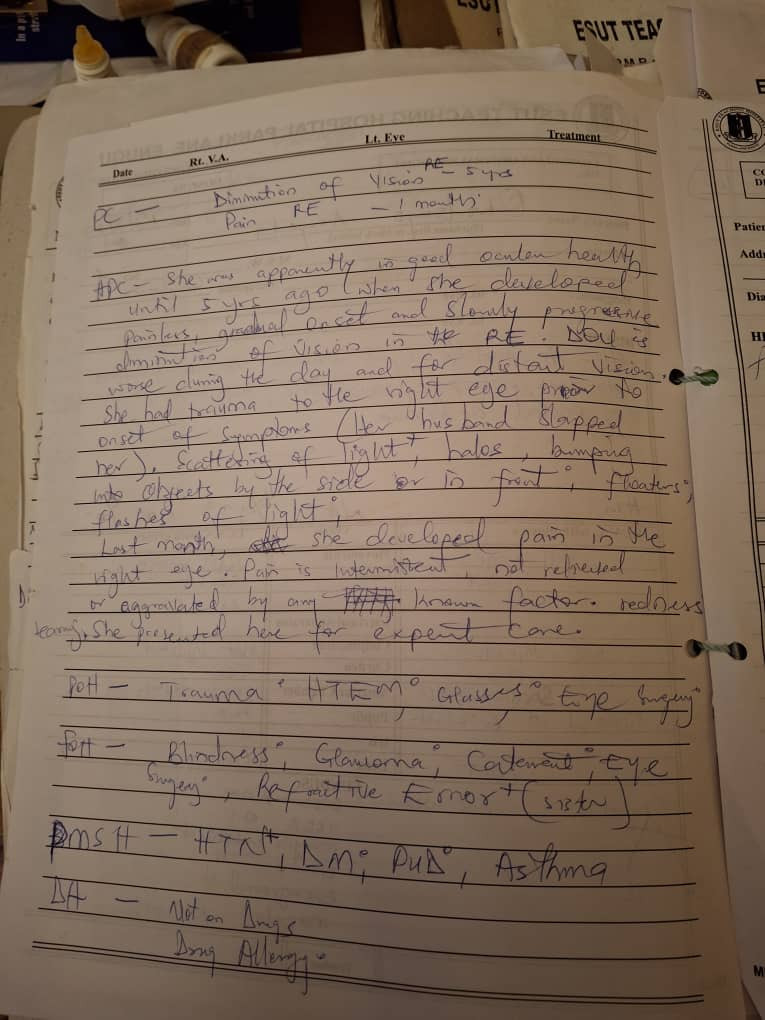

In [27]:
img

In [29]:
from IPython.display import Markdown

Markdown(res.md_text)



**R: V.C.**

**Lt. Eye**

**Treatment**

**Pain RE - 1 month**

**Hx -** She was apparently in good ocular health until Sept. 1990 when she developed prolonged onset and slowly progressive diminution of vision in the RE. Now is down to seeing the day and far distant vision. She had burning to the right eye prior to onset of symptoms. Now husband stopped her Tx. Cortisone at night + halos + flashes finished at night. 

Last month, she she developed pain in the right eye. Pain is intermittent, not relieved w/ paracetamol by any #### known factor. Perhaps conjunctive swelled due for expert care.

**POH -** Trauma? HTEM? Glasses? Eye surg?

**PH -** Blindness, Glaucoma, Cataract Eye Surg? Refractive Error? (sic)

**PMSH -** HTN?, DM?, PMS, Asthma

**DH -** Not on Meds 

**Drug Allergy -**

In [34]:
img = load_image(image_paths[0])
img64 = encode_image(image_paths[0])

client = openai.OpenAI()
client = instructor.from_openai(client, mode=instructor.Mode.MD_JSON)

r = client.chat.completions.create(
    model="gpt-4o",
    response_model=HandwrittenText,
    temperature=0.0,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Extract the text from the image."
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{img64}"
                    }
                }
            ]
        }
    ]
)

# res = client.chat.completions.create(
#     model="gpt-4o",
#     response_model=HandwrittenText,
#     temperature=0.7,
#     messages=[
#         {"role": "system", "content": """\
#             You are an expert handwritten text extractor.
#             You are given a handwritten doctor's note and you are asked to extract the text.
#             The text should be in markdown format.
#         """},
#         {
#             "role": "user",
#             "content": [
#                 {
#                     "type": "text",
#                     "text": "how are you?"
#                 },
#                 {
#                     "type": "image_url",
#                     "image_url": img64
#                 }
#             ]
#         }
#     ]
# )


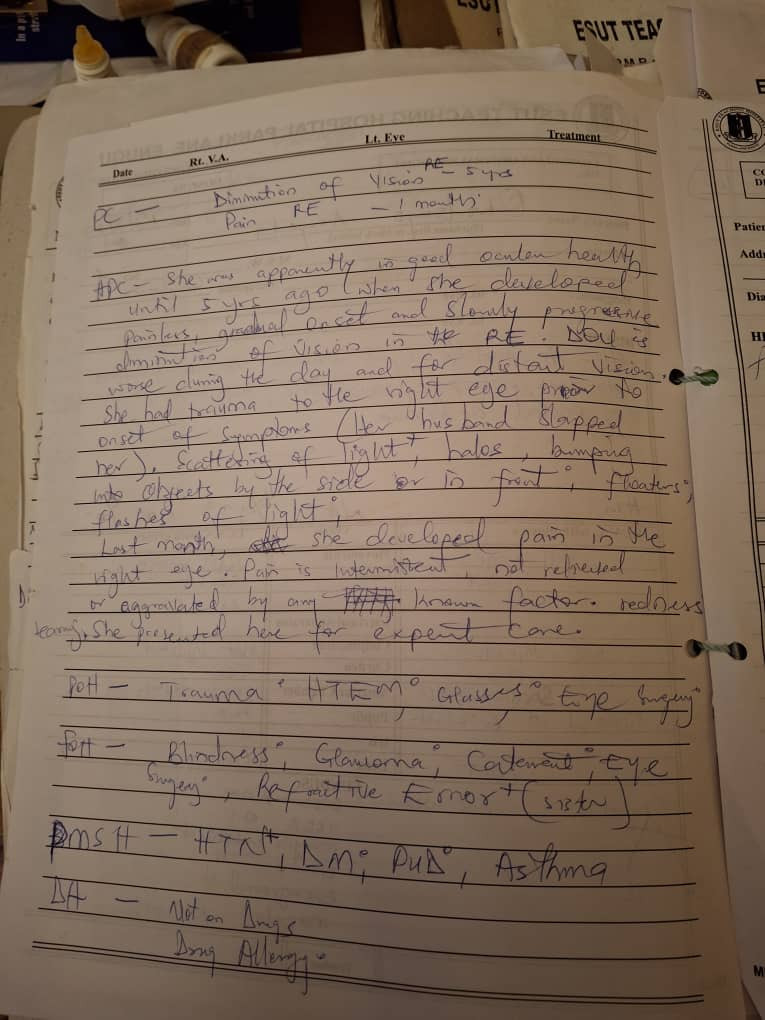

In [38]:
img

In [37]:
Markdown(r.md_text)



### Date:
Rt. V.A. Lt. Eye Treatment

### PC:
Diminution of Vision RE 5 yrs
Pain RE - 1 month

### HPC:
She was apparently in good ocular health until 5 yrs ago when she developed painless gradual onset and slowly progressive diminution of vision in the RE. Now it is worse during the day and for distant vision. She had trauma to the right eye prior to onset of symptoms (her husband slapped her). Seeing of light halos bumping into objects by the side or in front. Floaters, flashes of light. Last month, she developed pain in the right eye. Pain is intermittent, not relieved or aggravated by any known factor. Redness. She presented here for expert care.

### POH:
- Trauma
- HTEM
- Glasses
- Eye surgery

### POH:
- Blindness
- Glaucoma
- Cataract
- Eye surgery
- Refractive Error (sister)

### PMH:
- HTN
- DM
- PUD
- Asthma

### DA:
Not on drugs
Drug Allergy